In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/network-attack-dataset-kitsune/SSL Renegotiation/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../input/network-attack-dataset-kitsune/SSL Renegotiation/SSL_Renegotiation_labels.csv
../input/network-attack-dataset-kitsune/SSL Renegotiation/SSL_Renegotiation_dataset.csv
../input/network-attack-dataset-kitsune/SSL Renegotiation/SSL_Renegotiation_pcap.pcap


In [13]:
# Setup environment
!pip install pyspark
# !pip install sparkmagic

from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id


spark = SparkSession.builder.appName("outlier-detection").getOrCreate()

In [14]:
# Load Dataset
data = "../input/network-attack-dataset-kitsune/SSL Renegotiation/SSL_Renegotiation_dataset.csv"
df_data = spark.read.load(
        data,
        format="csv", sep=",",
        inferSchema="true",
        header="false")

df_data = df_data.withColumn("row_id", monotonically_increasing_id()) # starts with 0



In [15]:
# analyzing internal partitions

from pyspark.sql.functions import *
from pyspark.sql import Column

df_partition = df_data.withColumn("partition_id", shiftRight('row_id',33)).withColumn("row_offset", df_data['row_id'].bitwiseAND(2147483647))
partitions_size = df_partition.groupBy("partition_id").count().withColumnRenamed("count", "partition_size")
# partitions_size.show()
# partitions_size.count()


In [16]:
# Sum of the sizes of it preceding partitions
from pyspark.sql.window import Window

windowSpec = Window.orderBy("partition_id").rowsBetween(Window.unboundedPreceding, -1)

partitions_offset = partitions_size.withColumn("partition_offset",when(expr("partition_id = 0"), lit(0))
                                               .otherwise(sum("partition_size").over(windowSpec)))


In [17]:
# Final step joining with the original dataset
df_data = df_partition.join(broadcast(partitions_offset), "partition_id").withColumn("id", partitions_offset.partition_offset+df_partition.row_offset+1).drop("partition_id", "row_id", "row_offset", "partition_size", "partition_offset")
# df_data.printSchema()


In [18]:
df_data.select('id','_c0','_c114').orderBy('id', ascending=False).show()

+-------+------------------+--------------------+
|     id|               _c0|               _c114|
+-------+------------------+--------------------+
|2207571|58.622254457239116|0.002818600661436646|
|2207570|57.639826343497425|0.002818828188881594|
|2207569|115.51903996015112|                 0.0|
|2207568|114.55557165531172|                 0.0|
|2207567|113.55641613290923|                 0.0|
|2207566|112.65039028713795|                 0.0|
|2207565|111.65122059649201|                 0.0|
|2207564| 110.7190829343993|                 0.0|
|2207563|109.74728194832748|                 0.0|
|2207562|108.83169081274899|                 0.0|
|2207561|107.85566161244098|                 0.0|
|2207560|107.28270970204764|                 0.0|
|2207559|106.30519424576302|                 0.0|
|2207558|105.90029979728847|                 0.0|
|2207557|104.90099322902226|                 0.0|
|2207556|103.97992206099649|                 0.0|
|2207555| 102.9806027982874|                 0.0|


In [19]:
from pyspark.sql.types import StructType, StructField, LongType, IntegerType

# Load Labels
labels = "../input/network-attack-dataset-kitsune/SSL Renegotiation/SSL_Renegotiation_labels.csv"
labels_schema = StructType([StructField("id", LongType(), False),
                     StructField("labels", IntegerType(), False)])
df_labels = spark.read.load(
        labels,
        format="csv",
        sep=",",
        inferSchema="false",
        schema=labels_schema,
        header="true")
# df_labels.show()

In [20]:
from pyspark.sql.functions import *
from pyspark.sql import Column

#Assign random labels upto 3 categories 
from pyspark.sql.functions import rand,when
# df_labels = df_labels.withColumn('labels',round(rand()*3,0)).withColumn('labels', col('labels').cast(IntegerType()))
df_labels = df_labels.withColumn('labels', when(df_labels.labels == 1, lit(1)).otherwise(lit(0)))
df_labels.sample(0.5).show()


+---+------+
| id|labels|
+---+------+
|  2|     0|
|  3|     0|
|  8|     0|
|  9|     0|
| 10|     0|
| 11|     0|
| 13|     0|
| 15|     0|
| 16|     0|
| 18|     0|
| 21|     0|
| 24|     0|
| 26|     0|
| 27|     0|
| 28|     0|
| 30|     0|
| 31|     0|
| 32|     0|
| 33|     0|
| 34|     0|
+---+------+
only showing top 20 rows



In [21]:
#JOIN
df = df_data.join(df_labels, on=["id"], how="inner")
# df.groupBy('label').count().show()
df.count()

2207571

In [22]:
df = df.select("id","_c0","_c113","_c114","labels").sort("id", ascending=False).limit(100000)
df.count()

100000

In [23]:
# from pyspark.ml.feature import VectorAssembler
# from pyspark.sql import dataframe

# assembler = VectorAssembler(
#         inputCols=[x for x in df.columns if x != "labels"],
#         outputCol="features",
#         handleInvalid="skip"
#     )

# df = assembler.transform(df)
# df.select("features", "labels").show()

**SK LEARN CLASSIFIERS**

In [24]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics 

In [25]:
df_pd = df.toPandas()
df_pd.head()

,id,_c0,_c113,_c114,labels
0,2207571,58.622254,1.057178,0.002819,1
1,2207570,57.639826,1.057291,0.002819,1
2,2207569,115.519040,0.000000,0.000000,0
3,2207568,114.555572,0.000000,0.000000,0
4,2207567,113.556416,0.000000,0.000000,0


In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_pd.drop('labels', axis=1), df_pd['labels'],test_size=.3,random_state=22)

In [29]:
X_train.shape,X_test.shape

((70000, 4), (30000, 4))

In [31]:
#developing a model
clf_pruned = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_pruned.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=100)

**Visualizing**

In [33]:
#visualizing the tree
!pip install pydotplus
import io
from io import StringIO
from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz

     |████████████████████████████████| 278 kB 1.2 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24566 sha256=2f5445ef2d6873616aad1f1f5a785bacb670b2004a5af83894527fc62de23cac
  Stored in directory: /root/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


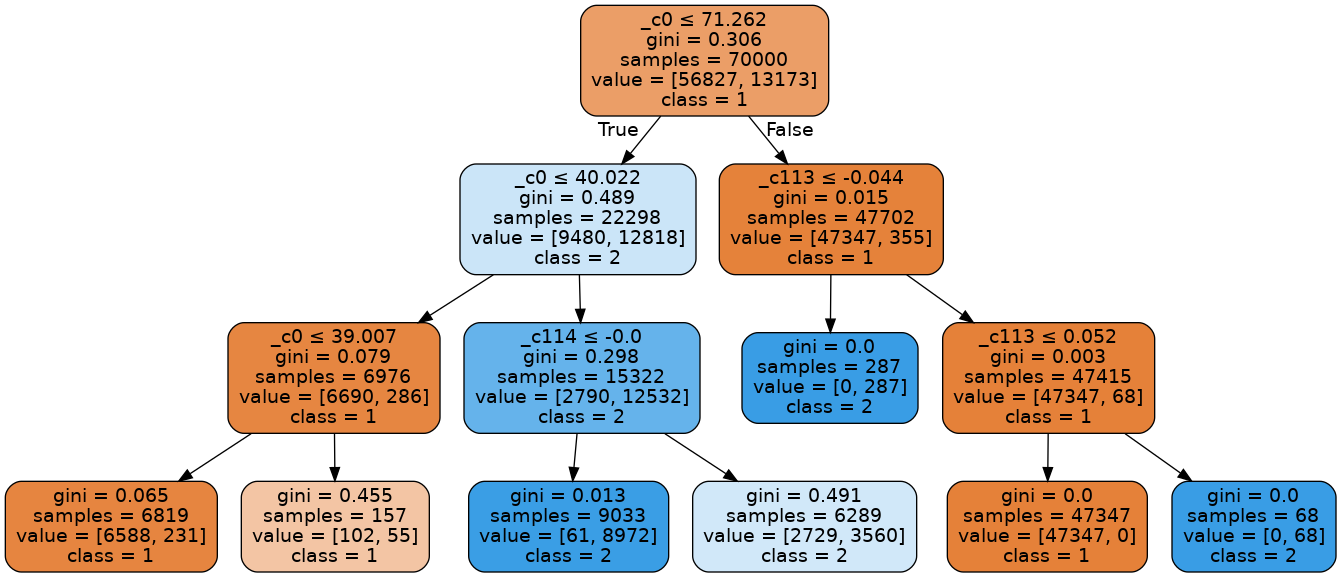

In [35]:
xvar = df_pd.drop('labels', axis=1)
feature_cols = xvar.columns
dot_data = StringIO()
export_graphviz(clf_pruned, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['1','2','3'])
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [38]:
## Calculating feature importance
feat_importance = clf_pruned.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(feature_cols, clf_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)


,FeatureImportance
_c0,0.883469
_c114,0.076625
_c113,0.039906
id,0.000000


In [41]:
pd.set_option("max_rows", 8)
feat_imp.sort_values(by=['FeatureImportance'], ascending=False)

,FeatureImportance
_c0,0.883469
_c114,0.076625
_c113,0.039906
id,0.000000


**SPARK ML PIPELINES**

In [ ]:
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier, MultilayerPerceptronClassifier, GBTClassifier, LinearSVC, OneVsRest, RandomForestClassifier
# Select the estimators
# estimator = NaiveBayes(smoothing=1.0, modelType="gaussian")
# estimator = DecisionTreeClassifier(labelCol="labels", featuresCol="features")
layers = [115, 5, 4, 3]
# estimator = MultilayerPerceptronClassifier(labelCol='label', featuresCol='features', maxIter=100, layers=layers, blockSize=128, seed=1234)
# gbt = GBTClassifier(labelCol="label", featuresCol="features")
# estimator = LinearSVC(maxIter=10, regParam=0.1)
# estimator = OneVsRest(classifier=gbt)
# estimator = RandomForestClassifier(labelCol="labels", featuresCol="features", numTrees=10),

In [ ]:
# pipeline = Pipeline().setStages([assembler, estimator])
# pipeline_model = pipeline.fit(trainingData)
# data = pipeline.getStages()[0].transform(trainingData)
# model = pipeline.getStages()[1].fit(data)

In [ ]:
# from pyspark.ml.base import Estimator, Model, Transformer
# display(isinstance(assembler, Estimator))
# display(isinstance(tf, Transformer))

In [ ]:
# !pip install pydotplus

In [ ]:
# from six import StringIO
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data3 = StringIO()
# export_graphviz(estimator, out_file=dot_data3,  
#                filled=True, rounded=True,
#                special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data3.getvalue())  
# Image(graph.create_png())

In [ ]:
# tf_df = pipeline_model.transform(testData)
# tf_df.printSchema()